In [3]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.firefox.options import Options
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import re
import time
import seaborn as sns

In [2]:
def scroll(driver, timeout, loops):
    scroll_pause_time = timeout

    last_height = driver.execute_script("return document.body.scrollHeight")
    num = 0
    
    while True and num < loops:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        num = num + 1
        time.sleep(scroll_pause_time)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

In [4]:
url = 'https://www.vivino.com/explore?e=eJwdijsOgCAQBW_zaqDfzo4jGGPWFQmJgAH83V5iM1PMxEIaMSRSiPyQ0UpBXhospMPi6NlvdHEJrvGOvFDhFpKvs-QzNWRaXRXcbZz6-st8itQcHw%3D%3D'
product_names = []
profile = webdriver.FirefoxProfile()
profile.set_preference("general.useragent.override", "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:81.0) Gecko/20100101 Firefox/81.0")
options = Options()
options.headless = True
browser = webdriver.Firefox(options=options)
options.add_argument("start-maximized")
options.add_argument('disable-infobars')
browser.get(url)

loops = 1
timeout = 5
scroll(browser, timeout, loops)

titles = browser.find_elements_by_class_name('vintageTitle__wine--U7t9G')
prices = browser.find_elements_by_xpath("(//*[contains(@class, 'addToCartButton__price')])")
ratings = browser.find_elements_by_class_name('vivinoRating__averageValue--3Navj')
reviews = browser.find_elements_by_class_name('vivinoRating__caption--3tZeS')
countries = browser.find_elements_by_xpath('//a[contains(@href, "/explore?country_code")]')
#for price in prices:
#    print('price:',price.text)
for title, price, rating, review, country in zip(titles, prices, ratings, reviews, countries):
    with open('vinData.csv', 'a', encoding='UTF8') as f:
        writer = csv.writer(f)
        date = 9999
        line = re.findall(r'\d+', title.text)
        
        if(len(line)>0):
            for l in line:
                if(len(str(l)) == 4):
                    date = l
                    
        data = [title.text, date, price.text.split("\n", 1)[0], rating.text, review.text.split(" ", 1)[0], country.text]
        writer.writerow(data)
                                

[]


In [4]:
df = pd.read_csv('vinData.csv', names=["Name", "Year", "Price", "Rating", "Review", "Country"])
df.head()

,Name,Year,Price,Rating,Review,Country
0,Edizione Cinque Autoctoni,9999,149.00,4.3,57745,Italy
1,Malbec 2018,2018,59.95,3.8,16764,Argentina
2,Malbec 2016,2016,129.95,4.1,16137,Argentina
3,Cabernet Sauvignon 2016,2016,1245.00,4.6,13942,United States
4,Malbec 2013,2013,99.95,3.9,13271,Argentina


In [5]:
df.describe()

,Year,Price,Rating,Review
count,450.000000,450.000000,450.000000,450.000000
mean,2104.351111,286.519067,4.023111,3169.573333
std,837.767652,287.901398,0.264026,4447.897243
min,1986.000000,39.950000,3.300000,1109.000000
25%,2015.000000,129.950000,3.800000,1425.500000
50%,2016.000000,181.500000,4.000000,1980.500000
75%,2018.000000,305.000000,4.200000,3365.250000
max,9999.000000,1995.000000,4.700000,57754.000000


In [6]:
sorted_df = df.copy()
sorted_df.drop(sorted_df[df.Review < 1500].index, inplace=True)
print(sorted_df)

                            Name  Year    Price  Rating  Review        Country
0      Edizione Cinque Autoctoni  9999   149.00     4.3   57745          Italy
1                    Malbec 2018  2018    59.95     3.8   16764      Argentina
2                    Malbec 2016  2016   129.95     4.1   16137      Argentina
3        Cabernet Sauvignon 2016  2016  1245.00     4.6   13942  United States
4                    Malbec 2013  2013    99.95     3.9   13271      Argentina
..                           ...   ...      ...     ...     ...            ...
445              Pinot Noir 2019  2019    99.00     4.0    4070  United States
446   Scaia Rosso (Corvina) 2015  2015   112.50     3.8    4022          Italy
447  Pinot Grigio Valdadige 2016  2016   135.00     3.8    3981          Italy
448        Les Darons Rouge 2017  2017   250.00     3.8    3940         France
449      Cabernet Sauvignon 2015  2015   129.95     4.0    3939      Argentina

[316 rows x 6 columns]


In [9]:
def plot_rating(df):
    
    #Delete all with low review numbers
    sorted_df = df.copy()
    #sorted_df.drop(sorted_df[df.Review < 1500].index, inplace=True)
    
    #Extract Country & Rating columns
    cols = ['Country', 'Rating']
    mask = sorted_df[cols]
    print('Lowest rated',mask.min(),'\n')
    print('Median rated',mask.mean(),'\n')
    print('Highest rated ',mask.max(),'\n')
    
    #Group rows by Country
    mask_by_country = mask.groupby('Country')
    
    #Get Min, Median & Max rating for each country
    min_rating = mask_by_country.min()
    median_rating = mask_by_country.mean()
    max_rating = mask_by_country.max()
    
    df_stats = pd.DataFrame()
    df_stats['Min'] = min_rating['Rating']
    df_stats['Median'] = median_rating['Rating']
    df_stats['Max'] = max_rating['Rating']
    ax = df_stats.plot(kind='bar', figsize=(15,10), width=0.7)
    plt.xticks(rotation=45)
    plt.xlabel('Country')
    plt.ylabel('Rating pr. country');
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)
    
    #Data on each bar
    #for p in ax.patches:
    #    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, (p.get_height()) * 1.005), rotation=90)
    
def describe(df):
    return df.describe()

plotbar = df.copy()
#plot_rating(plotbar)
plotbar

,Name,Year,Price,Rating,Review,Country
0,Edizione Cinque Autoctoni,9999,149.00,4.3,57745,Italy
1,Malbec 2018,2018,59.95,3.8,16764,Argentina
2,Malbec 2016,2016,129.95,4.1,16137,Argentina
3,Cabernet Sauvignon 2016,2016,1245.00,4.6,13942,United States
4,Malbec 2013,2013,99.95,3.9,13271,Argentina
...,...,...,...,...,...,...
445,Pinot Noir 2019,2019,99.00,4.0,4070,United States
446,Scaia Rosso (Corvina) 2015,2015,112.50,3.8,4022,Italy
447,Pinot Grigio Valdadige 2016,2016,135.00,3.8,3981,Italy
448,Les Darons Rouge 2017,2017,250.00,3.8,3940,France


In [39]:
cols = ['Country', 'Rating']
mask = df[cols]
mask.info()
mask

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Country  400 non-null    object 
 1   Rating   400 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.4+ KB


,Country,Rating
0,Italy,4.3
1,Argentina,3.8
2,Argentina,4.1
3,United States,4.6
4,Argentina,3.9
...,...,...
395,United States,4.5
396,Italy,4.2
397,Portugal,4.2
398,Portugal,4.1


In [40]:
mask_by_country = mask.groupby('Country')
type(mask_by_country)
mask_by_country.describe()

Rating                                                  
               count      mean       std  min    25%   50%    75%  max
Country                                                               
Argentina       62.0  4.072581  0.306310  3.5  3.825  4.10  4.200  4.7
Australia        8.0  3.987500  0.223207  3.7  3.925  4.00  4.025  4.4
Austria          1.0  3.800000       NaN  3.8  3.800  3.80  3.800  3.8
Chile            9.0  3.877778  0.130171  3.7  3.800  3.80  4.000  4.1
France          50.0  3.948000  0.282294  3.5  3.700  3.90  4.200  4.7
Hungary          1.0  3.900000       NaN  3.9  3.900  3.90  3.900  3.9
Israel           1.0  3.800000       NaN  3.8  3.800  3.80  3.800  3.8
Italy          104.0  4.023077  0.215529  3.5  3.900  4.00  4.200  4.5
Lebanon          2.0  4.050000  0.212132  3.9  3.975  4.05  4.125  4.2
New Zealand      6.0  4.100000  0.268328  3.6  4.100  4.15  4.200  4.4
Portugal        15.0  4.006667  0.208624  3.7  3.900  4.00  4.100  4.5
South Africa     8.0  3.875000  0.260494  3.5  3.700  3.80  4.125  4.2
Spain           57.0  4.019298  0.287501  3.3  3.800  4.00  4.200  4.7
United States   72.0  4.005556  0.260492  3.5  3.800  4.00  4.100  4.7
Uruguay          4.0  4.075000  0.150000  3.9  3.975  4.10  4.200  4.2

In [41]:
min_rating = mask_by_country.min()
median_rating = mask_by_country.mean()
max_rating = mask_by_country.max()
median_rating

,Rating
Country,
Argentina,4.072581
Australia,3.987500
Austria,3.800000
Chile,3.877778
France,3.948000
Hungary,3.900000
Israel,3.800000
Italy,4.023077
Lebanon,4.050000


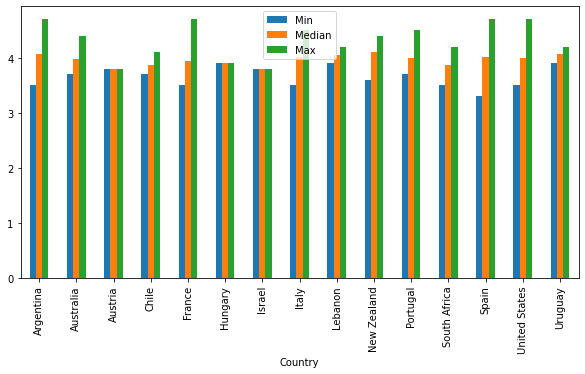

In [42]:
newdf = pd.DataFrame()
newdf['Min'] = min_rating['Rating']
newdf['Median'] = median_rating['Rating']
newdf['Max'] = max_rating['Rating']
newdf.plot(kind='bar', figsize=(10,5))

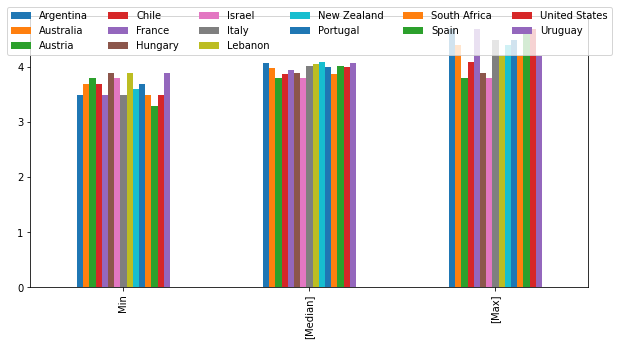

In [44]:
mydata = [min_rating['Rating'], median_rating['Rating'], max_rating['Rating']]
headers = ['Min', ['Median'], ['Max']]
newdf = pd.DataFrame(mydata, headers)
newdf.plot(kind='bar', figsize=(10,5))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=6)

In [77]:
median_rating.idxmax()

Rating    Lebanon
dtype: object

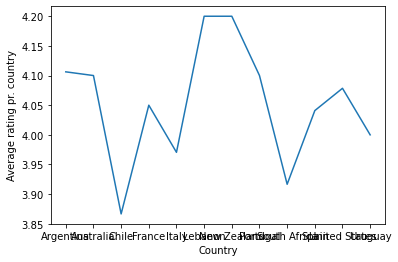

In [78]:
plt.plot(median_rating.index, median_rating)
plt.xlabel('Country')
plt.ylabel('Average rating pr. country');